# Breakpoints
* Breakpoints stop the app at one specific step. This is very useful when you want to include a human-in-the-loop task.

#### When will we want to include a human-in-the-loop task?
Mostly, in one of the following situations:
* `Approval`: pause and ask if user approves to proceed with a particular step.
* `Debugging`: pause and perform just one task to debug it.
* `Editing`: pause and modify the state.

## Setup

#### After you download the code from the github repository in your computer
In terminal:
* cd project_name
* pyenv local 3.11.4
* poetry install
* poetry shell

#### To open the notebook with Jupyter Notebooks
In terminal:
* jupyter lab

Go to the folder of notebooks and open the right notebook.

#### To see the code in Virtual Studio Code or your editor of choice.
* open Virtual Studio Code or your editor of choice.
* open the project-folder
* open the 016-breakpoints.py file

## Create your .env file
* In the github repo we have included a file named .env.example
* Rename that file to .env file and here is where you will add your confidential api keys. Remember to include:
* OPENAI_API_KEY=your_openai_api_key
* LANGCHAIN_TRACING_V2=true
* LANGCHAIN_ENDPOINT=https://api.smith.langchain.com
* LANGCHAIN_API_KEY=your_langchain_api_key
* LANGCHAIN_PROJECT=your_project_name

## Track operations
From now on, we can track the operations **and the cost** of this project from LangSmith:
* [smith.langchain.com](https://smith.langchain.com)

## Connect with the .env file located in the same directory of this notebook

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [1]:
#pip install python-dotenv

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())
openai_api_key = os.environ["OPENAI_API_KEY"]

#### Install LangChain

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [3]:
#!pip install langchain

## Connect with an LLM

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [4]:
#!pip install langchain-openai

In [5]:
from langchain_openai import ChatOpenAI

chatModel35 = ChatOpenAI(model="gpt-3.5-turbo-0125")
chatModel4o = ChatOpenAI(model="gpt-4o")

## How to use a breakpoint to pause the app execution and ask the user if he approves or rejects to proceed with a particular step
* Let's assume that we want the user to approve or reject if the agent will use any of its tools.
* All we need to do is to compile the graph with **interrupt_before=["tools"]** where "tools" is the tools node.
* Doing that, the execution will be interrupted before the node "tools" is executed.

In [6]:
from langchain_openai import ChatOpenAI

# Let's define several tools
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

llm = ChatOpenAI(model="gpt-4o")

llm_with_tools = llm.bind_tools(tools)

* See that when we compile the graph we introduce the breakpoint interrupt_before=["tools"]:

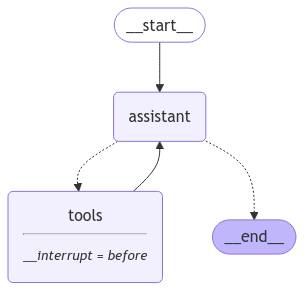

In [7]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# PAY ATTENTION HERE: this is the function we will use 
# in the "assistant" node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes
builder.add_node("assistant", assistant)

# PAY ATTENTION HERE: see how we use ToolNode in the "tools" node
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")

# PAY ATTENTION HERE: see how the conditional edge will route the app
# to the assistant node, the tools node, or the END node
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()

# PAY ATTENTION HERE: This is where we introduce 
# the breakpoint interrupt_before=["tools"]
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

* See how now when we run the app it stops before using a tool.

In [8]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# PAY ATTENTION HERE: this runs the graph, but since the graph
# has a breakpoint configured, it will pause the execution 
# before using a tool.
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_daSNNy2ZSBPFZTieNCvNLmvU)
 Call ID: call_daSNNy2ZSBPFZTieNCvNLmvU
  Args:
    a: 2
    b: 3


* We can see that the state has stopped at the breakpoint:

In [9]:
state = graph.get_state(thread)
state.next

('tools',)

* If we now invoke the graph with **None** instead of initial_input, LangGraph will re-emit the current state first and then it will continue executing from the last state checkpoint.

In [10]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_daSNNy2ZSBPFZTieNCvNLmvU)
 Call ID: call_daSNNy2ZSBPFZTieNCvNLmvU
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


* But we want to do this with a Human-in-the-loop task. Let's see how to do that next.

## How to use a basic logic to add a human-in-the loop approval step
* See how **if you run the following code you will be asked, at the breakpoint, if you want to call the tool**.

In [11]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# Thread
thread = {"configurable": {"thread_id": "2"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

# PAY ATTENTION HERE: The app asks for user approval
user_approval = input("Do you want to call the tool? (yes/no): ")

# PAY ATTENTION HERE: The app will proceed based on user approval
if user_approval.lower() == "yes":
    
    # If approved, the app will continue the execution
    for event in graph.stream(None, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()

# If not approved, the app will not continue the execution 
# and will print the following message:    
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_A7ew5c8WL8NfweBsqk8lpUqJ)
 Call ID: call_A7ew5c8WL8NfweBsqk8lpUqJ
  Args:
    a: 2
    b: 3


Do you want to call the tool? (yes/no):  yes


================================== Ai Message ==================================
Tool Calls:
  multiply (call_A7ew5c8WL8NfweBsqk8lpUqJ)
 Call ID: call_A7ew5c8WL8NfweBsqk8lpUqJ
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## How to execute the code from Visual Studio Code
* In Visual Studio Code, see the file 016-breakpoints.py
* In terminal, make sure you are in the directory of the file and run:
    * python 016-breakpoints.py